# Comparació de diferents models d'optimització de carteres

Explicació del codi

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sco
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Funcions

#### Tractament de dades

In [2]:
# Funció per calcular els rendiments logarítmics
def calcula_rendiments(dades):
    return  np.log(dades / dades.shift(1)).dropna()

#### Comuns

In [3]:
# Funció per calcular el rendiment anualitzat i la volatilitat
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252  # rendiment anualitzat
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # volatilitat anualitzada
    return std, returns

In [4]:
# Simulació de carteres aleatòries
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(dades.columns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0, i] = portfolio_std_dev
        results[1, i] = portfolio_return
        results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std_dev  # Ràtio de Sharpe
    return results, weights_record

In [5]:


# Mostrar la frontera eficient amb carteres aleatòries
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)

    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0, max_sharpe_idx], results[1, max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=dades.columns, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i * 100, 2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0, min_vol_idx], results[1, min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx], index=dades.columns, columns=['allocation'])
    min_vol_allocation.allocation = [round(i * 100, 2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    print("-" * 80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp, 2))
    print("Annualised Volatility:", round(sdp, 2))
    print("\n", max_sharpe_allocation)
    print("-" * 80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min, 2))
    print("Annualised Volatility:", round(sdp_min, 2))
    print("\n", min_vol_allocation)

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp, rp, marker='*', color='r', s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min, rp_min, marker='*', color='g', s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing=0.8)
    plt.show()

#### Markowitz

In [6]:
# Funció per calcular el portafoli amb el màxim Sharpe
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets * [1. / num_assets, ], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [7]:
# Funció per calcular la volatilitat d'una cartera
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

In [8]:
# Funció per obtenir la frontera eficient
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = (
        {'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    )
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility,
                          num_assets * [1. / num_assets],
                          args=args,
                          method='SLSQP',
                          bounds=bounds,
                          constraints=constraints)
    return result

#### Random Forest

In [9]:
# Model Random Forest per predir rendiments futurs
def random_forest_prediction(rendiments, n_estimators=100, test_size=0.2):
    X = rendiments.shift(1).dropna()
    y = rendiments.iloc[1:].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    model = RandomForestRegressor(n_estimators=n_estimators)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse:.6f}')

    return model

In [10]:
# Nova funció: Rolling Forecast per prediccions multihoritzó
def rolling_forecast(model, recent_data, steps=10):
    predictions = []
    current_input = recent_data.reshape(1, -1)
    
    for _ in range(steps):
        pred = model.predict(current_input)
        predictions.append(pred.flatten())
        current_input = pred  # Usa la predicció com a nova entrada
    
    return np.array(predictions)

#### LSTM

## Execució

#### Tractament de dades

In [11]:
# Carregar les dades
dades = pd.read_csv('dades_borses.csv', index_col=0, parse_dates=True)
dades

,SAP.DE,BAYN.DE,BMW.DE,ALV.DE,DTE.DE,VOW3.DE,ADS.DE,FRE.DE,DBK.DE,MUV2.DE
Index,,,,,,,,,,
2019-01-02,77.922653,49.249485,48.311951,128.805817,11.976306,80.847679,175.456146,38.271378,6.475193,147.565613
2019-01-03,75.504623,49.200932,47.833969,127.451523,12.065199,79.957687,175.027969,36.516460,6.428999,146.664886
2019-01-04,77.412170,52.518761,49.676662,130.542847,12.158134,83.351555,181.783600,39.370422,6.735142,149.484589
2019-01-07,77.573380,51.685257,49.960690,129.482956,12.174295,83.446495,180.499069,38.936123,6.839303,147.565613
2019-01-08,78.782379,53.020473,50.023029,129.615448,12.012670,84.846771,184.875977,37.987759,6.904517,145.920776
...,...,...,...,...,...,...,...,...,...,...
2023-12-21,135.861237,32.328640,93.745338,229.412308,20.321455,104.025497,193.829056,28.570000,11.935375,365.759552
2023-12-22,136.512985,32.417850,94.771782,230.314209,20.438757,104.117996,183.580292,28.610001,12.028651,368.460297
2023-12-27,138.092987,33.171173,94.545776,229.459778,20.316761,104.340004,184.995987,28.370001,12.048082,365.084351


In [12]:
# Calcular rendiments logarítmics
rendiments = calcula_rendiments(dades)
rendiments

,SAP.DE,BAYN.DE,BMW.DE,ALV.DE,DTE.DE,VOW3.DE,ADS.DE,FRE.DE,DBK.DE,MUV2.DE
Index,,,,,,,,,,
2019-01-03,-0.031523,-0.000986,-0.009943,-0.010570,0.007395,-0.011069,-0.002443,-0.046939,-0.007160,-0.006123
2019-01-04,0.024950,0.065258,0.037799,0.023965,0.007673,0.041570,0.037871,0.075252,0.046520,0.019043
2019-01-07,0.002080,-0.015998,0.005701,-0.008152,0.001328,0.001138,-0.007091,-0.011092,0.015347,-0.012920
2019-01-08,0.015465,0.025506,0.001247,0.001023,-0.013365,0.016641,0.023960,-0.024658,0.009490,-0.011209
2019-01-09,0.013661,0.001068,0.010196,0.005888,-0.006411,0.024044,-0.002319,0.011368,-0.028070,0.007220
...,...,...,...,...,...,...,...,...,...,...
2023-12-21,-0.011706,0.001841,-0.008701,-0.002480,-0.000692,-0.011142,-0.007788,0.002804,-0.000976,-0.004736
2023-12-22,0.004786,0.002756,0.010890,0.003924,0.005756,0.000889,-0.054324,0.001399,0.007785,0.007357
2023-12-27,0.011508,0.022972,-0.002388,-0.003717,-0.005987,0.002130,0.007682,-0.008424,0.001614,-0.009205


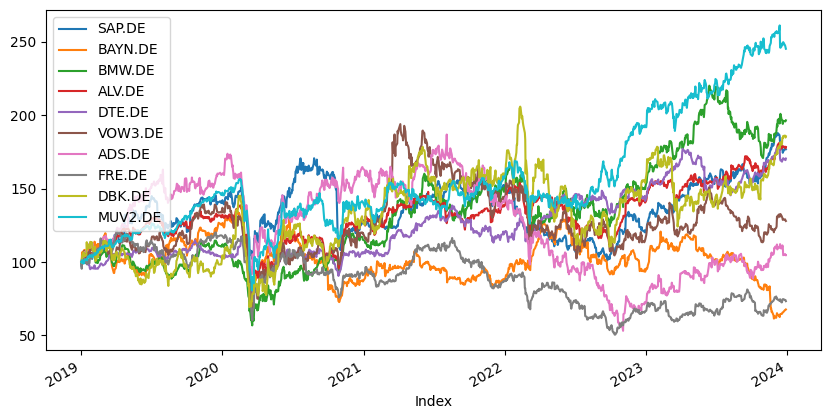

In [13]:
# Visualització dels rendiments normalitzats
(dades / dades.iloc[0] * 100).plot(figsize=(10, 5))
plt.show()

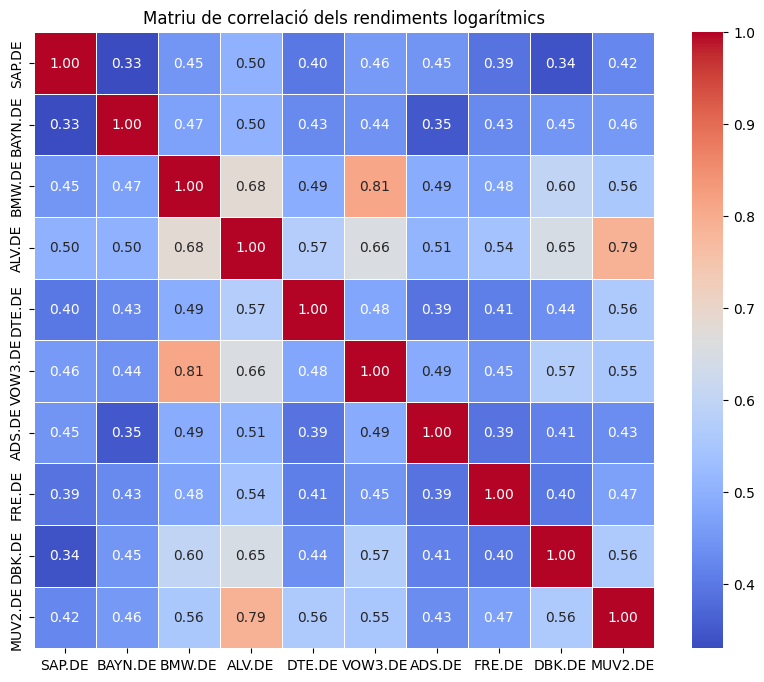

In [14]:
# Calcular la matriu de correlació
matriu_correlacio = rendiments.corr()

# Visualitzar la matriu amb un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(matriu_correlacio, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriu de correlació dels rendiments logarítmics")
plt.show()

In [15]:
# Càlcul de mitjanes i covariàncies basades en log-rendiments
mean_returns = rendiments.mean()
cov_matrix = rendiments.cov()

mean_returns
cov_matrix

,SAP.DE,BAYN.DE,BMW.DE,ALV.DE,DTE.DE,VOW3.DE,ADS.DE,FRE.DE,DBK.DE,MUV2.DE
SAP.DE,0.000308,0.000117,0.000151,0.000144,0.000092,0.000184,0.000177,0.000129,0.000159,0.000132
BAYN.DE,0.000117,0.000410,0.000182,0.000165,0.000113,0.000206,0.000161,0.000162,0.000240,0.000163
BMW.DE,0.000151,0.000182,0.000366,0.000213,0.000124,0.000355,0.000212,0.000170,0.000304,0.000188
ALV.DE,0.000144,0.000165,0.000213,0.000266,0.000123,0.000245,0.000188,0.000165,0.000279,0.000227
DTE.DE,0.000092,0.000113,0.000124,0.000123,0.000171,0.000144,0.000116,0.000101,0.000151,0.000130
VOW3.DE,0.000184,0.000206,0.000355,0.000245,0.000144,0.000525,0.000253,0.000191,0.000346,0.000224
ADS.DE,0.000177,0.000161,0.000212,0.000188,0.000116,0.000253,0.000512,0.000166,0.000246,0.000173
FRE.DE,0.000129,0.000162,0.000170,0.000165,0.000101,0.000191,0.000166,0.000351,0.000198,0.000155
DBK.DE,0.000159,0.000240,0.000304,0.000279,0.000151,0.000346,0.000246,0.000198,0.000698,0.000262
MUV2.DE,0.000132,0.000163,0.000188,0.000227,0.000130,0.000224,0.000173,0.000155,0.000262,0.000313


#### Markowitz

In [16]:
# Paràmetres
num_portfolios = 100000
risk_free_rate = 0.01136  # Taxa lliure de risc (exemple)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.12
Annualised Volatility: 0.21

             SAP.DE  BAYN.DE  BMW.DE  ALV.DE  DTE.DE  VOW3.DE  ADS.DE  FRE.DE  \
allocation   19.12     0.59   12.13    8.87   23.71     2.51    2.19    0.51   

            DBK.DE  MUV2.DE  
allocation    6.98    23.38  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.07
Annualised Volatility: 0.2

             SAP.DE  BAYN.DE  BMW.DE  ALV.DE  DTE.DE  VOW3.DE  ADS.DE  FRE.DE  \
allocation   19.55     6.54    9.45     3.3   25.49     0.09    2.65    20.0   

            DBK.DE  MUV2.DE  
allocation    2.85    10.09  


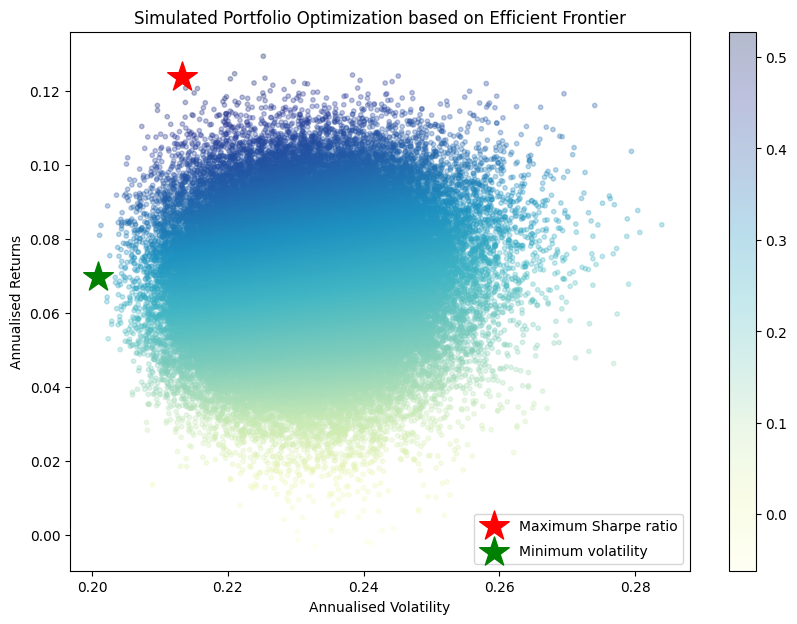

In [17]:
# Mostrar carteres simulades i la frontera eficient
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

#### Random Forest

In [18]:
# Entrenament del model
model_rf = random_forest_prediction(rendiments)

Mean Squared Error: 0.000295


In [19]:
# Prediccions recursives pels pròxims 10 dies
last_known_input = rendiments.shift(1).iloc[-1].values
future_returns = rolling_forecast(model_rf, last_known_input, steps=10)

/home/maria/Documents/Uni/TFG/Codi/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/maria/Documents/Uni/TFG/Codi/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/maria/Documents/Uni/TFG/Codi/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/maria/Documents/Uni/TFG/Codi/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/maria/Documents/Uni/TFG/Codi/.venv/lib/python3.11/site-packages/sklearn/utils/validati

In [20]:
# Rendiments esperats (mitjana de les prediccions)
mean_returns = future_returns.mean(axis=0)

In [21]:
# Covariància històrica (es pot millorar posteriorment)
cov_matrix = rendiments.cov()

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.46
Annualised Volatility: 0.23

             SAP.DE  BAYN.DE  BMW.DE  ALV.DE  DTE.DE  VOW3.DE  ADS.DE  FRE.DE  \
allocation     3.0     7.69    29.0    0.81    7.66     2.16   20.06    4.09   

            DBK.DE  MUV2.DE  
allocation    2.09    23.44  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.08
Annualised Volatility: 0.2

             SAP.DE  BAYN.DE  BMW.DE  ALV.DE  DTE.DE  VOW3.DE  ADS.DE  FRE.DE  \
allocation   18.29     7.94    0.83     8.3   27.51     3.85    4.24   23.28   

            DBK.DE  MUV2.DE  
allocation    1.73     4.04  


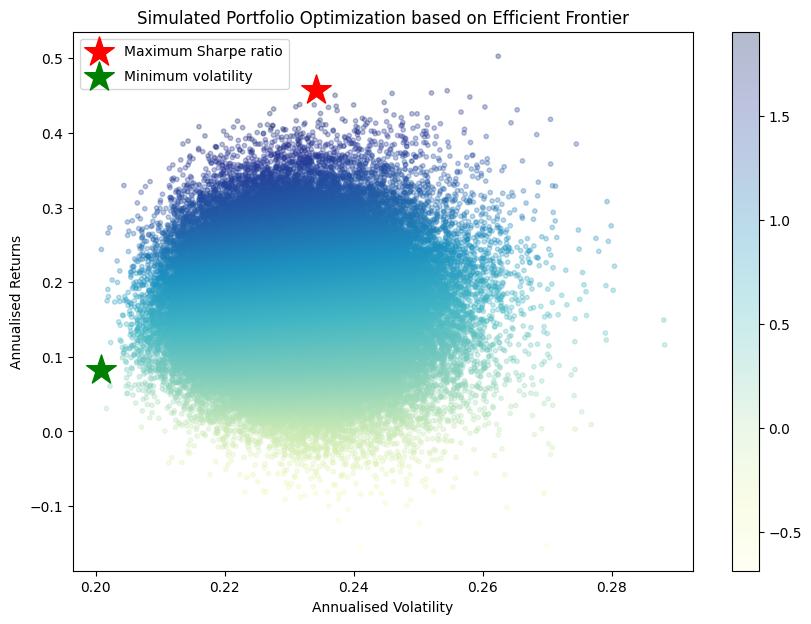

In [22]:
# Paràmetres
num_portfolios = 100000
risk_free_rate = 0.01136  # Exemple de taxa lliure de risc

# Executar la simulació i mostrar resultats
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)